# Test boundary states

2022.10.20

In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra

In [62]:
include("../src/SailorMoon.jl")   # relative path to main file of module

Main.SailorMoon

### Test initial state

In [63]:
param3b = SailorMoon.dyanmics_parameters()

Main.SailorMoon.dynamics_params(0.987849414390376, 0.01215058560962404, 328900.5598102475, 384748.32292972936, 375700.3437894195, 388.8212386592645, -0.9251999994040079, 0.9251999994040079, 0.01709689063726318, 7.601281331451572)

In [64]:
thetas = LinRange(0, 2π, 100)
xs_earth_circle = [-param3b.mu2*cos(theta) for theta in thetas];
ys_earth_circle = [-param3b.mu2*sin(theta) for theta in thetas];

In [65]:
# dv, long, lat
param_vinf = [0.1, deg2rad(25), 0]
θ1 = deg2rad(90)
sv_start = SailorMoon.set_initial_state(param3b, param_vinf, θ1)

6-element Vector{Float64}:
  0.015495045118665611
 -0.004925127407333037
  0.007225458202291004
  3.2659438512729455
  6.979731240854539
  0.0

In [76]:
xs_earth_circ = [6378/param3b.lstar*cos(theta) + param3b.mu2*cos(π+θ1) for theta in thetas];
ys_earth_circ = [6378/param3b.lstar*sin(theta) + param3b.mu2*sin(π+θ1) for theta in thetas];
xs_moon_circle = [(1-param3b.mu2)*cos(theta) for theta in thetas];
ys_moon_circle = [(1-param3b.mu2)*sin(theta) for theta in thetas];

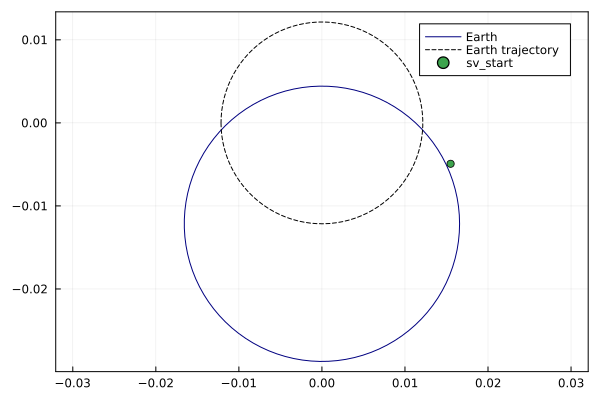

In [67]:
pcart = plot(size=(600,400), frame_style=:box, aspect_ratio=:equal)

plot!(pcart, xs_earth_circ, ys_earth_circ, color=:navy, linestyle=:solid, label="Earth")
plot!(pcart, xs_earth_circle, ys_earth_circle, color=:black, linestyle=:dash, label="Earth trajectory")

#scatter!(pcart, [earth0_in[1]], [earth0_in[2]], label="earth0_in")
scatter!(pcart, [sv_start[1]], [sv_start[2]], label="sv_start")

pcart

### Test final state

In [68]:
include("../../julia-r3bp/R3BP/src/R3BP.jl")

Main.R3BP

In [69]:
lp = 2
Az_km = 28000.0
println("Halo guess Az_km: $Az_km")
northsouth = 3   # 1 or 3
guess0 = R3BP.halo_analytical_construct(param3b.mu2, lp, Az_km, param3b.lstar, northsouth)
res = R3BP.ssdc_periodic_xzplane([param3b.mu2,], guess0.x0, guess0.period, fix="z")
res.flag

Halo guess Az_km: 28000.0


1

In [70]:
x0_stm = vcat(res.x0, reshape(I(6), (6^2,)))[:]
prob_cr3bp_stm = ODEProblem(R3BP.rhs_cr3bp_svstm!, x0_stm, res.period, (param3b.mu2))
sol = solve(prob_cr3bp_stm, Tsit5(), reltol=1e-12, abstol=1e-12)#, saveat=LinRange(0, period, n+1))
monodromy = R3BP.get_stm(sol, 6)   # get monodromy matrix

6×6 transpose(::Matrix{Float64}) with eltype Float64:
   526.766   33.4496  -235.23      86.322    129.383   -26.8157
  -794.087  -49.3932   354.126   -129.383   -195.409    40.3292
  -163.682  -10.0361    74.0455   -26.8157   -40.3292    8.14178
  1638.19   103.613   -732.652    268.001    403.268   -83.0233
 -1255.93   -79.1926   561.559   -206.094   -308.159    63.6676
 -1440.9    -91.0981   644.194   -235.23    -354.126    74.0455

In [71]:
ys0 = R3BP.get_eigenvector(monodromy, true, 1)

Linear stability ν = 290.9383214356218


6-element Vector{Float64}:
 -0.1954811166094517
 -0.29399446049543554
  0.060738148589877576
  0.6067152007112099
  0.4667342148543378
 -0.534528863077809

In [72]:
# arrival LPO object
LPOArrival = SailorMoon.CR3BPLPO(
    res.x0, res.period, ys0, prob_cr3bp_stm, 1e-6, Tsit5(), 1e-12, 1e-12
);

In [80]:
ϕ = 0.5
θm = deg2rad(210)

sv_end = SailorMoon.set_terminal_state(ϕ, θm, param3b, LPOArrival)

6-element Vector{Float64}:
 -1.0123695062569602
 -0.5844916658523779
  0.09812983722130537
  0.44343209920301835
 -0.7680485739300638
  0.0981301728155214

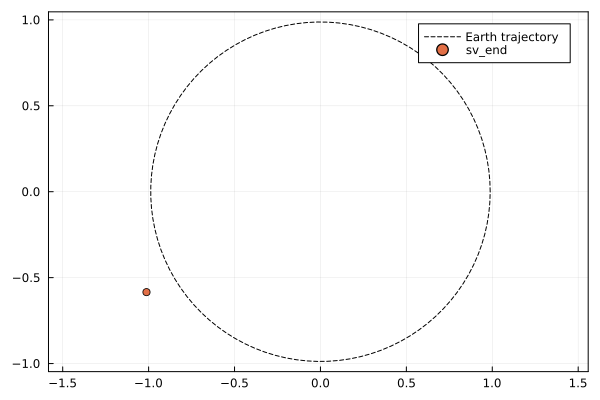

In [82]:
pcart = plot(size=(600,400), frame_style=:box, aspect_ratio=:equal)

#plot!(pcart, xs_earth_circ, ys_earth_circ, color=:navy, linestyle=:solid, label="Earth")
plot!(pcart, xs_moon_circle, ys_moon_circle, color=:black, linestyle=:dash, label="Earth trajectory")

#scatter!(pcart, [earth0_in[1]], [earth0_in[2]], label="earth0_in")
scatter!(pcart, [sv_end[1]], [sv_end[2]], label="sv_end")

pcart

### Test ballistic backward propagation